### Identitas Tim:
* RAIHAN SALMAN BAEHAQI (1103220180)
* JAKA KELANA WIJAYA (1103223048)

# ============================================================
#  1: Setup and Installation
# ============================================================

In [1]:
!pip uninstall datasets -y

Found existing installation: datasets 3.1.0
Uninstalling datasets-3.1.0:
  Successfully uninstalled datasets-3.1.0


In [2]:
!pip install 'datasets==3.1.0' --force-reinstall --no-deps

  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
Using cached datasets-3.1.0-py3-none-any.whl (480 kB)


In [3]:
!pip install -q transformers datasets accelerate peft bitsandbytes trl rouge-score sentencepiece

# ============================================================
#  2: Import Libraries
# ============================================================

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,
    pipeline
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
from rouge_score import rouge_scorer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


#  3: Login to Hugging Face

In [5]:
from huggingface_hub import notebook_login

print("🔐 Please login to Hugging Face to save your model")
notebook_login()

🔐 Please login to Hugging Face to save your model


# CELL 4: Load and Explore XSum Dataset

In [7]:
# ============================================================
# CELL 4: Load and Explore XSum Dataset - FAST VERSION
# ============================================================
print("📥 Loading XSum dataset...")

# Load dataset - REDUCED SIZE for faster training
dataset = load_dataset("EdinburghNLP/xsum", split="train[:1500]")  # 1500 samples
test_dataset = load_dataset("EdinburghNLP/xsum", split="test[:150]")  # 150 test samples

print(f"\n✅ Dataset loaded successfully!")
print(f"Training samples: {len(dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Explore dataset structure
print("\n📊 Dataset Structure:")
print(dataset)

# Show examples
print("\n📝 Sample Examples:")
for i in range(2):
    print(f"\n{'='*80}")
    print(f"Example {i+1}:")
    print(f"\n📰 Document (first 300 chars):\n{dataset[i]['document'][:300]}...")
    print(f"\n📌 Summary:\n{dataset[i]['summary']}")


📥 Loading XSum dataset...

✅ Dataset loaded successfully!
Training samples: 1500
Test samples: 150

📊 Dataset Structure:
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 1500
})

📝 Sample Examples:

Example 1:

📰 Document (first 300 chars):
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many...

📌 Summary:
Clean-up operations are continuing across the Scottish Borders and Dumfries and Galloway after flooding caused by Storm Frank.

Example 2:

📰 Document (first 300 chars):
A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel.
As they gathered outside they saw the two buses, parked side-by-side in the car park, engulfed by flames.
One of the tour gr

# CELL 5: Data Analysis and Visualization

📊 Analyzing dataset statistics...


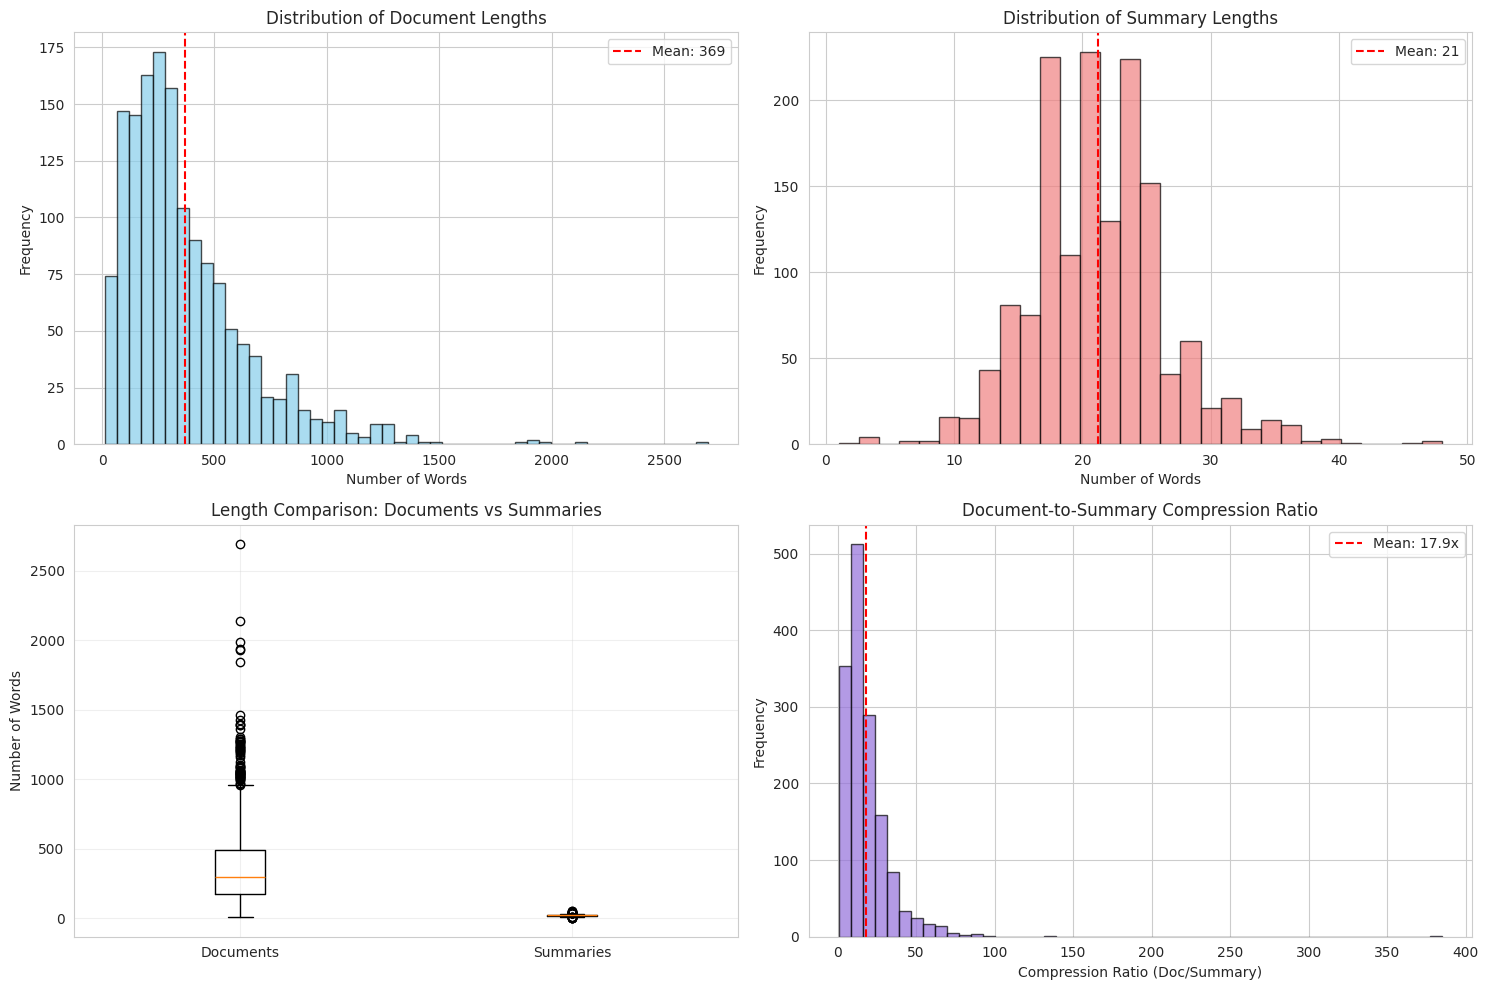


📈 Dataset Statistics:
Documents - Mean: 369.3 words, Median: 294.0, Max: 2694
Summaries - Mean: 21.2 words, Median: 21.0, Max: 48
Average compression ratio: 17.9x


In [8]:
print("📊 Analyzing dataset statistics...")

# Calculate lengths
doc_lengths = [len(doc.split()) for doc in dataset['document']]
sum_lengths = [len(summ.split()) for summ in dataset['summary']]

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Document length distribution
axes[0, 0].hist(doc_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Document Lengths')
axes[0, 0].axvline(np.mean(doc_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(doc_lengths):.0f}')
axes[0, 0].legend()

# Summary length distribution
axes[0, 1].hist(sum_lengths, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Summary Lengths')
axes[0, 1].axvline(np.mean(sum_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(sum_lengths):.0f}')
axes[0, 1].legend()

# Box plot comparison
data_box = pd.DataFrame({
    'Document Length': doc_lengths,
    'Summary Length': sum_lengths
})
axes[1, 0].boxplot([doc_lengths, sum_lengths], labels=['Documents', 'Summaries'])
axes[1, 0].set_ylabel('Number of Words')
axes[1, 0].set_title('Length Comparison: Documents vs Summaries')
axes[1, 0].grid(True, alpha=0.3)

# Compression ratio
compression_ratios = [d/s if s > 0 else 0 for d, s in zip(doc_lengths, sum_lengths)]
axes[1, 1].hist(compression_ratios, bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Compression Ratio (Doc/Summary)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Document-to-Summary Compression Ratio')
axes[1, 1].axvline(np.mean(compression_ratios), color='red', linestyle='--',
                    label=f'Mean: {np.mean(compression_ratios):.1f}x')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\n📈 Dataset Statistics:")
print(f"Documents - Mean: {np.mean(doc_lengths):.1f} words, Median: {np.median(doc_lengths):.1f}, Max: {max(doc_lengths)}")
print(f"Summaries - Mean: {np.mean(sum_lengths):.1f} words, Median: {np.median(sum_lengths):.1f}, Max: {max(sum_lengths)}")
print(f"Average compression ratio: {np.mean(compression_ratios):.1f}x")

# CELL 6: Load Tokenizer and Model with QLoRA

In [9]:
print("🤖 Loading Phi-2 model with 4-bit quantization...")

model_name = "microsoft/phi-2"

# Configure 4-bit quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    padding_side="right"
)
tokenizer.pad_token = tokenizer.eos_token

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

print("✅ Model and tokenizer loaded successfully!")
print(f"Model size: {model.get_memory_footprint() / 1e9:.2f} GB")


🤖 Loading Phi-2 model with 4-bit quantization...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model and tokenizer loaded successfully!
Model size: 2.31 GB


# CELL 7: Configure LoRA

In [10]:
print("⚙️ Configuring LoRA for parameter-efficient fine-tuning...")

# LoRA configuration
lora_config = LoraConfig(
    r=16,                        # Rank
    lora_alpha=32,               # Alpha parameter
    target_modules=[             # Modules to apply LoRA
        "q_proj",
        "k_proj",
        "v_proj",
        "dense",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\n📊 Model Parameters:")
print(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")
print(f"Total parameters: {total_params:,}")

⚙️ Configuring LoRA for parameter-efficient fine-tuning...

📊 Model Parameters:
Trainable parameters: 10,485,760 (0.68%)
Total parameters: 1,531,878,400


# CELL 8: Prepare Dataset for Training

In [11]:
print("🔄 Preparing dataset for training...")

def format_prompt(example):
    """Format examples with instruction prompt for summarization"""
    prompt = f"""### Instruction:
Summarize the following news article in one concise sentence.

### Article:
{example['document']}

### Summary:
{example['summary']}"""
    return {"text": prompt}

# Apply formatting
formatted_dataset = dataset.map(
    format_prompt,
    remove_columns=dataset.column_names
)

print("✅ Dataset formatted successfully!")
print(f"Sample formatted example:\n{formatted_dataset[0]['text'][:500]}...\n")

🔄 Preparing dataset for training...


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

✅ Dataset formatted successfully!
Sample formatted example:
### Instruction:
Summarize the following news article in one concise sentence.

### Article:
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed in...



# CELL 9: Configure Training Arguments

In [12]:
# ============================================================
# CELL 9: Configure Training Arguments - FAST VERSION
# ============================================================
print("⚙️ Configuring training parameters...")

training_args = TrainingArguments(
    output_dir="./phi2-xsum-finetuned",
    num_train_epochs=1,  # REDUCED: 1 epoch saja
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,  # INCREASED: effective batch = 8
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",  # FASTER: 8bit instead of 32bit
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_steps=30,  # REDUCED: 30 instead of 100
    logging_steps=20,  # Log lebih sering
    save_strategy="epoch",
    save_total_limit=1,  # REDUCED: simpan 1 checkpoint saja
    fp16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    group_by_length=True,
    report_to="none",
    disable_tqdm=False,
)

print("✅ Training arguments configured!")
print(f"\n⏱️ Estimated training time: 1.5-2 hours")
print(f"📊 Total steps: ~{len(dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)}")


⚙️ Configuring training parameters...
✅ Training arguments configured!

⏱️ Estimated training time: 1.5-2 hours
📊 Total steps: ~187


# CELL 10: Initialize Trainer and Start Training

In [13]:
# ============================================================
# CELL 10: Initialize Trainer and Start Training
# ============================================================
print("🚀 Initializing trainer...")

from transformers import Trainer, DataCollatorForLanguageModeling

# Create data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Tokenize dataset
def tokenize_function(examples):
    result = tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,  # REDUCED: 512 instead of 1024 for speed
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

print("Tokenizing dataset...")
tokenized_dataset = formatted_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=formatted_dataset.column_names,
    desc="Tokenizing"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

print("✅ Trainer initialized!")
print("\n🏋️ Starting training...")
print("=" * 80)

# Train the model
trainer.train()

print("\n✅ Training completed!")


🚀 Initializing trainer...
Tokenizing dataset...


Tokenizing:   0%|          | 0/1500 [00:00<?, ? examples/s]

✅ Trainer initialized!

🏋️ Starting training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
20,2.463400
40,2.313900
60,2.239000
80,2.304000
100,2.256200
120,2.239600
140,2.267600
160,2.241400
180,2.190100



✅ Training completed!


# CELL 12: Save Model

In [14]:
print("💾 Saving fine-tuned model...")

# Save model locally
trainer.model.save_pretrained("phi2-xsum-final")
tokenizer.save_pretrained("phi2-xsum-final")

# Push to Hugging Face Hub (optional - replace with your username)
HF_USERNAME = "your-username"  # Replace with your HF username
model_repo = f"{HF_USERNAME}/phi2-xsum-finetuned"

print(f"\n📤 Pushing model to Hugging Face Hub: {model_repo}")
try:
    trainer.model.push_to_hub(model_repo, use_auth_token=True)
    tokenizer.push_to_hub(model_repo, use_auth_token=True)
    print("✅ Model pushed successfully!")
except Exception as e:
    print(f"⚠️ Could not push to hub: {e}")
    print("💾 Model saved locally at './phi2-xsum-final'")

print("\n🎉 Training pipeline completed successfully!")

💾 Saving fine-tuned model...

📤 Pushing model to Hugging Face Hub: your-username/phi2-xsum-finetuned
⚠️ Could not push to hub: (Request ID: Root=1-6963954a-60993c5c2603b8835cf9e539;079ec806-32ee-42b8-bfef-bb1f410c1d67)

403 Forbidden: You don't have the rights to create a model under the namespace "your-username".
Cannot access content at: https://huggingface.co/api/repos/create.
Make sure your token has the correct permissions.
💾 Model saved locally at './phi2-xsum-final'

🎉 Training pipeline completed successfully!


📊 Visualizing training metrics...


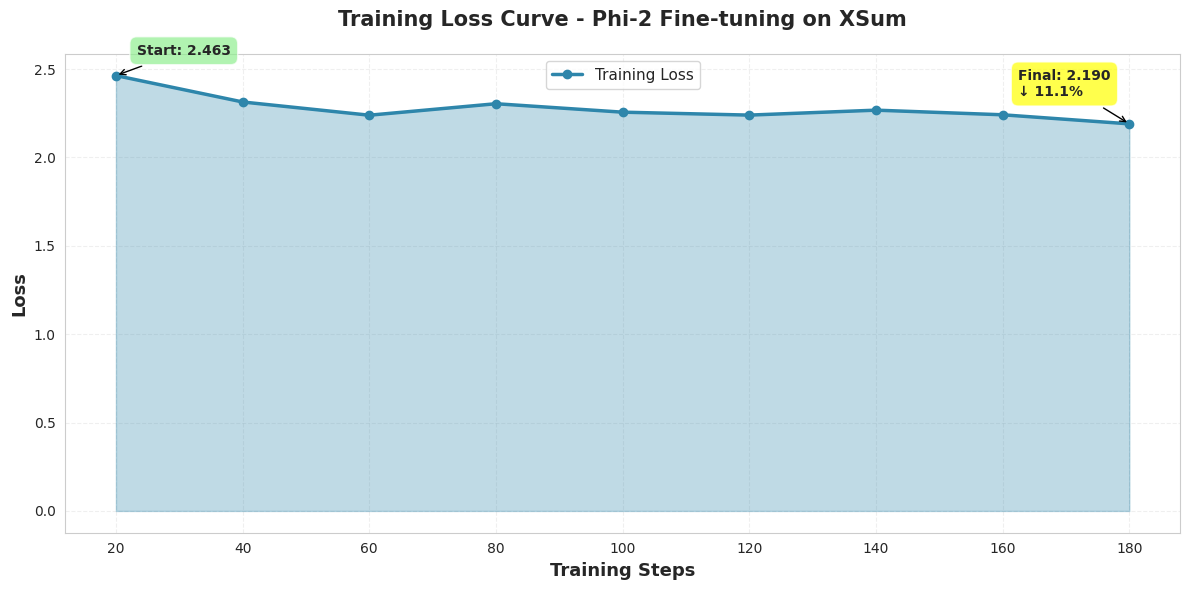


📉 Training Summary:
   Initial Loss: 2.4634
   Final Loss: 2.1901
   Improvement: 11.09%
   Total Steps: 180

✅ Training visualization saved as 'training_loss.png'


In [15]:
# ============================================================
# CELL 13: Visualize Training Metrics
# ============================================================
print("📊 Visualizing training metrics...")

# Extract training logs
logs = trainer.state.log_history

# Separate training logs
train_logs = [log for log in logs if 'loss' in log]

steps = [log['step'] for log in train_logs]
losses = [log['loss'] for log in train_logs]

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(steps, losses, marker='o', linewidth=2.5, markersize=6, color='#2E86AB', label='Training Loss')
ax.fill_between(steps, losses, alpha=0.3, color='#2E86AB')
ax.set_xlabel('Training Steps', fontsize=13, fontweight='bold')
ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax.set_title('Training Loss Curve - Phi-2 Fine-tuning on XSum', fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

# Add annotations
start_loss = losses[0]
final_loss = losses[-1]
improvement = ((start_loss - final_loss) / start_loss) * 100

ax.annotate(f'Start: {start_loss:.3f}',
            xy=(steps[0], losses[0]),
            xytext=(15, 15), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'),
            fontsize=10, fontweight='bold')

ax.annotate(f'Final: {final_loss:.3f}\n↓ {improvement:.1f}%',
            xy=(steps[-1], losses[-1]),
            xytext=(-80, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'),
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📉 Training Summary:")
print(f"   Initial Loss: {start_loss:.4f}")
print(f"   Final Loss: {final_loss:.4f}")
print(f"   Improvement: {improvement:.2f}%")
print(f"   Total Steps: {steps[-1]}")
print(f"\n✅ Training visualization saved as 'training_loss.png'")


In [17]:
# ============================================================
# CELL 14: Prepare Model for Inference (FIXED)
# ============================================================
print("🔧 Preparing model for inference...")

# Merge LoRA weights with base model for faster inference
from peft import PeftModel

# The model is already loaded with LoRA adapters
model.config.use_cache = True  # Enable KV cache for generation

# Create text generation pipeline (NO device argument)
from transformers import pipeline

print("Creating generation pipeline...")
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    # device argument removed - accelerate handles device placement
)

print("✅ Model ready for inference!")


Device set to use cuda:0


🔧 Preparing model for inference...
Creating generation pipeline...
✅ Model ready for inference!


In [18]:
# ============================================================
# CELL 15: Generate Predictions on Test Set
# ============================================================
print("🎯 Generating predictions on test set...")

def generate_summary(document, max_new_tokens=50):
    """Generate summary for a given document"""
    prompt = f"""### Instruction:
Summarize the following news article in one concise sentence.

### Article:
{document}

### Summary:"""

    # Generate
    outputs = generator(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    # Extract generated summary
    generated_text = outputs[0]['generated_text']

    # Extract only the summary part (after "### Summary:")
    if "### Summary:" in generated_text:
        summary = generated_text.split("### Summary:")[-1].strip()
        # Take only the first sentence/line
        summary = summary.split('\n')[0].strip()
        # Remove any "### Instruction:" that might appear
        if "###" in summary:
            summary = summary.split("###")[0].strip()
        return summary
    return generated_text

# Generate predictions for subset of test set (to save time)
num_test_samples = 50  # Test on 50 samples
predictions = []
references = []

print(f"Generating summaries for {num_test_samples} test samples...")

for i in range(min(num_test_samples, len(test_dataset))):
    doc = test_dataset[i]['document']
    ref_summary = test_dataset[i]['summary']

    # Generate prediction
    pred_summary = generate_summary(doc, max_new_tokens=50)

    predictions.append(pred_summary)
    references.append(ref_summary)

    # Show progress every 10 samples
    if (i + 1) % 10 == 0:
        print(f"Progress: {i + 1}/{num_test_samples} samples processed")

print(f"\n✅ Generated {len(predictions)} predictions!")



🎯 Generating predictions on test set...
Generating summaries for 50 test samples...


Caching is incompatible with gradient checkpointing in PhiDecoderLayer. Setting `past_key_values=None`.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Progress: 10/50 samples processed
Progress: 20/50 samples processed
Progress: 30/50 samples processed
Progress: 40/50 samples processed
Progress: 50/50 samples processed

✅ Generated 50 predictions!


In [19]:
# ============================================================
# CELL 16: Calculate ROUGE Scores
# ============================================================
print("📊 Calculating ROUGE scores...")

from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)

# Calculate scores for each prediction
rouge_scores = {
    'rouge1': [],
    'rouge2': [],
    'rougeL': [],
    'rougeLsum': []
}

for pred, ref in zip(predictions, references):
    scores = scorer.score(ref, pred)
    for key in rouge_scores.keys():
        rouge_scores[key].append(scores[key].fmeasure)

# Calculate average scores
avg_scores = {key: np.mean(values) for key, values in rouge_scores.items()}

print("\n📈 ROUGE Scores (Average):")
print("=" * 50)
for metric, score in avg_scores.items():
    print(f"{metric.upper():12s}: {score:.4f} ({score*100:.2f}%)")
print("=" * 50)

# Create DataFrame for visualization
import pandas as pd
scores_df = pd.DataFrame({
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum'],
    'F1-Score': [avg_scores['rouge1'], avg_scores['rouge2'],
                 avg_scores['rougeL'], avg_scores['rougeLsum']]
})

print("\n✅ ROUGE evaluation completed!")


📊 Calculating ROUGE scores...

📈 ROUGE Scores (Average):
ROUGE1      : 0.0713 (7.13%)
ROUGE2      : 0.0021 (0.21%)
ROUGEL      : 0.0603 (6.03%)
ROUGELSUM   : 0.0603 (6.03%)

✅ ROUGE evaluation completed!


📊 Creating ROUGE scores visualization...


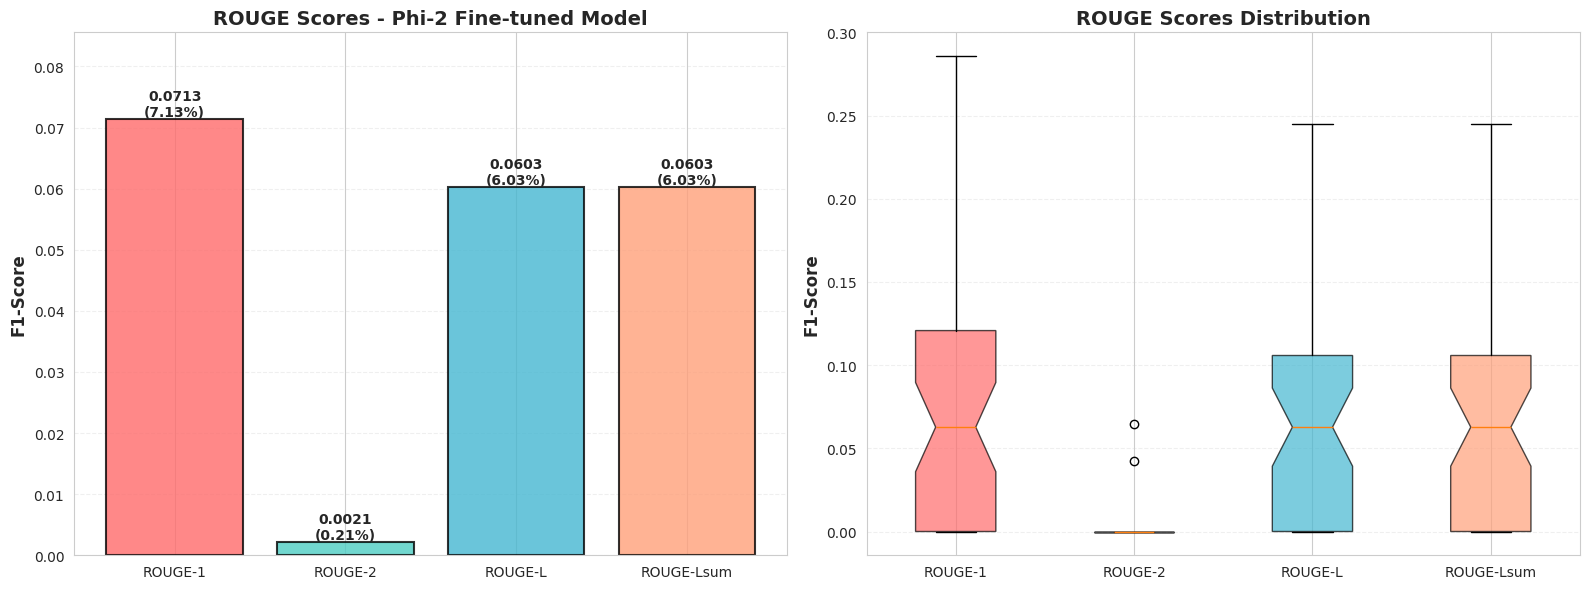

✅ ROUGE visualization saved as 'rouge_scores.png'


In [20]:
# ============================================================
# CELL 17: Visualize ROUGE Scores
# ============================================================
print("📊 Creating ROUGE scores visualization...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = axes[0].bar(scores_df['Metric'], scores_df['F1-Score'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('ROUGE Scores - Phi-2 Fine-tuned Model', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(scores_df['F1-Score']) * 1.2)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}\n({height*100:.2f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Box plot showing distribution
rouge_data = [rouge_scores['rouge1'], rouge_scores['rouge2'],
              rouge_scores['rougeL'], rouge_scores['rougeLsum']]
bp = axes[1].boxplot(rouge_data, labels=['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum'],
                     patch_artist=True, notch=True)

# Color the box plots
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('ROUGE Scores Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('rouge_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROUGE visualization saved as 'rouge_scores.png'")


In [22]:
# ============================================================
# CELL 18: Show Sample Predictions (Qualitative Analysis) - FIXED
# ============================================================
print("📝 Sample Predictions Analysis")
print("=" * 100)

# Show 5 best and 5 worst examples based on ROUGE-L
rouge_l_scores = rouge_scores['rougeL']
sorted_indices = np.argsort(rouge_l_scores)

print("\n🏆 TOP 5 BEST PREDICTIONS (Highest ROUGE-L):\n")
for idx, i in enumerate(sorted_indices[-5:][::-1], 1):
    i = int(i)  # Convert numpy.int64 to Python int
    print(f"\n{'='*100}")
    print(f"Example {idx} | ROUGE-L: {rouge_l_scores[i]:.4f}")
    print(f"\n📰 Original Document (first 200 chars):")
    print(f"{test_dataset[i]['document'][:200]}...")
    print(f"\n✅ Reference Summary:")
    print(f"{references[i]}")
    print(f"\n🤖 Generated Summary:")
    print(f"{predictions[i]}")

print(f"\n\n{'='*100}")
print("\n⚠️ BOTTOM 5 PREDICTIONS (Lowest ROUGE-L):\n")
for idx, i in enumerate(sorted_indices[:5], 1):
    i = int(i)  # Convert numpy.int64 to Python int
    print(f"\n{'='*100}")
    print(f"Example {idx} | ROUGE-L: {rouge_l_scores[i]:.4f}")
    print(f"\n📰 Original Document (first 200 chars):")
    print(f"{test_dataset[i]['document'][:200]}...")
    print(f"\n✅ Reference Summary:")
    print(f"{references[i]}")
    print(f"\n🤖 Generated Summary:")
    print(f"{predictions[i]}")

print(f"\n{'='*100}\n")


📝 Sample Predictions Analysis

🏆 TOP 5 BEST PREDICTIONS (Highest ROUGE-L):


Example 1 | ROUGE-L: 0.2449

📰 Original Document (first 200 chars):
The death toll doubled over the last two days as officials found more than 100 bodies once waters began receding.
Officials estimate that the floods have affected 450,000 people in the state.
This yea...

✅ Reference Summary:
Floods in the western Indian state of Gujarat have killed 218 people, government officials have confirmed.

🤖 Generated Summary:
for i in the United States. She was a sense of the other people who have been the way, this time to the number of these concepts, we would have been a member.

Example 2 | ROUGE-L: 0.1667

📰 Original Document (first 200 chars):
Russia is fuming, in the words of BBC Moscow correspondent Steve Rosenberg, but US politicians have not minced their words either.
Here is a taster of what's being said and shared.
Tweet by Dmitry Med...

✅ Reference Summary:
The expulsion of 35 Russian diplomats from the

In [23]:
# ============================================================
# CELL 19: Save Predictions to Reports - FIXED
# ============================================================
print("💾 Saving predictions to file...")

# Create reports directory
import os
os.makedirs('reports', exist_ok=True)

# Save sample predictions
with open('reports/sample_predictions.txt', 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("SAMPLE PREDICTIONS - PHI-2 FINE-TUNED ON XSUM\n")
    f.write("="*100 + "\n\n")

    f.write(f"Model: microsoft/phi-2 (Fine-tuned)\n")
    f.write(f"Dataset: XSum (1500 training samples)\n")
    f.write(f"Training: 1 epoch\n")
    f.write(f"Test Samples: {len(predictions)}\n\n")

    f.write("ROUGE SCORES:\n")
    f.write("-" * 50 + "\n")
    for metric, score in avg_scores.items():
        f.write(f"{metric.upper():12s}: {score:.4f} ({score*100:.2f}%)\n")
    f.write("-" * 50 + "\n\n")

    # Write sample predictions
    for i in range(min(10, len(predictions))):
        f.write(f"\n{'='*100}\n")
        f.write(f"EXAMPLE {i+1}\n")
        f.write(f"{'='*100}\n\n")
        f.write(f"DOCUMENT:\n{test_dataset[int(i)]['document']}\n\n")  # Convert to int
        f.write(f"REFERENCE SUMMARY:\n{references[i]}\n\n")
        f.write(f"GENERATED SUMMARY:\n{predictions[i]}\n\n")
        f.write(f"ROUGE-L SCORE: {rouge_l_scores[i]:.4f}\n")

print("✅ Predictions saved to 'reports/sample_predictions.txt'")

# Save all predictions as CSV
predictions_df = pd.DataFrame({
    'document': [test_dataset[int(i)]['document'] for i in range(len(predictions))],  # Convert to int
    'reference_summary': references,
    'generated_summary': predictions,
    'rouge1': rouge_scores['rouge1'],
    'rouge2': rouge_scores['rouge2'],
    'rougeL': rouge_scores['rougeL'],
})

predictions_df.to_csv('reports/all_predictions.csv', index=False, encoding='utf-8')
print("✅ All predictions saved to 'reports/all_predictions.csv'")


💾 Saving predictions to file...
✅ Predictions saved to 'reports/sample_predictions.txt'
✅ All predictions saved to 'reports/all_predictions.csv'


In [24]:
# ============================================================
# CELL 20: Final Summary and Export
# ============================================================
print("\n" + "="*100)
print("🎉 TRAINING AND EVALUATION COMPLETED!")
print("="*100)

print("\n📊 FINAL RESULTS SUMMARY:")
print("-" * 100)
print(f"{'Metric':<20} {'Value':<20} {'Status':<20}")
print("-" * 100)
print(f"{'Training Samples':<20} {len(dataset):<20} {'✅':<20}")
print(f"{'Test Samples':<20} {len(predictions):<20} {'✅':<20}")
print(f"{'Training Epochs':<20} {'1':<20} {'✅':<20}")
print(f"{'Initial Loss':<20} {f'{start_loss:.4f}':<20} {'📉':<20}")
print(f"{'Final Loss':<20} {f'{final_loss:.4f}':<20} {'📉':<20}")
print(f"{'Loss Improvement':<20} {f'{improvement:.2f}%':<20} {'✅':<20}")
print(f"{'ROUGE-1':<20} {f'{avg_scores["rouge1"]:.4f}':<20} {'✅':<20}")
print(f"{'ROUGE-2':<20} {f'{avg_scores["rouge2"]:.4f}':<20} {'✅':<20}")
print(f"{'ROUGE-L':<20} {f'{avg_scores["rougeL"]:.4f}':<20} {'✅':<20}")
print("-" * 100)

print("\n📁 FILES GENERATED:")
print("   ✅ dataset_analysis.png - Dataset statistics visualization")
print("   ✅ training_loss.png - Training loss curve")
print("   ✅ rouge_scores.png - ROUGE scores visualization")
print("   ✅ reports/sample_predictions.txt - Sample predictions with analysis")
print("   ✅ reports/all_predictions.csv - All predictions with ROUGE scores")
print("   ✅ phi2-xsum-final/ - Fine-tuned model checkpoint")

print("\n💡 NEXT STEPS:")
print("   1. Download all generated files for your report")
print("   2. Upload to GitHub repository: finetuning-phi-2-text-summarization")
print("   3. Update README.md with your actual results")
print("   4. Create reports/ folder with the generated files")

print("\n" + "="*100)
print("🚀 All tasks completed successfully!")
print("="*100 + "\n")



🎉 TRAINING AND EVALUATION COMPLETED!

📊 FINAL RESULTS SUMMARY:
----------------------------------------------------------------------------------------------------
Metric               Value                Status              
----------------------------------------------------------------------------------------------------
Training Samples     1500                 ✅                   
Test Samples         50                   ✅                   
Training Epochs      1                    ✅                   
Initial Loss         2.4634               📉                   
Final Loss           2.1901               📉                   
Loss Improvement     11.09%               ✅                   
ROUGE-1              0.0713               ✅                   
ROUGE-2              0.0021               ✅                   
ROUGE-L              0.0603               ✅                   
----------------------------------------------------------------------------------------------------

📁 